## About

This starter code shows how to read slides and tumor masks from the [CAMELYON16](https://camelyon17.grand-challenge.org/Data/) dataset. It will install [OpenSlide](https://openslide.org/) in Colab (the only non-Python dependency). Note that OpenSlide also includes a [DeepZoom viewer](https://github.com/openslide/openslide-python/tree/master/examples/deepzoom), shown in class. To use that, you'll need to install and run OpenSlide locally on your computer.

### Training data

The original slides and annotations are in an unusual format. I converted a bunch of them for you, so you can read them with OpenSlide as shown in this notebook. This [folder](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing) contains all the slides and tumor masks I converted (and these should be *plenty* for your project). If you'd like more beyond this, you'll need to use ASAP as described on the competition website to convert it into an appropriate format. 

Note that even with the starter code, it will take some effort to understand how to work with this data (the various zoom levels, and the coordinate system). Happy to help if you're stuck (please catch me in office hours, or right after class).

### Goals and grading

The goal for your project is to build a thoughtful, end-to-end prototype - not to match the accuracy from the [paper](https://arxiv.org/abs/1703.02442), and not necessarily to use all the available data. To receive an A on this work, your project should (for example):
- Use multiple zoom levels
- Use high-magnification images
- Include several visualizations of your results (both heatmaps showing predictions on individual slides, and other metrics/diagrams you design that are appropriate to communicate how well your model performs).

You are also welcome to propose a custom project of similar scope, happy to chat with you about your ideas anytime.

In [15]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [17]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Get all slides and masks files. 

In [18]:
slide_all=[filename for filename in os.listdir('./drive/My Drive/4995/slides') if (filename[-3:]=='tif' and 'mask' not in filename)]
mask_all=[filename for filename in os.listdir('./drive/My Drive/4995/slides') if ('mask' in filename)]

Keep slides and masks only if both files exist for each pair. 

In [19]:
mask_numbers=set([filename[-12:-9] for filename in mask_all])
slide_numbers=set([filename[-7:-4] for filename in slide_all])

slide_all=[filename for filename in slide_all if filename[-7:-4] in mask_numbers.intersection(slide_numbers)]
mask_all=[filename for filename in mask_all if filename[-12:-9] in mask_numbers.intersection(slide_numbers)]

In [20]:
assert len(slide_all)==len(mask_all), "Slide files and mask files don't match"
print('Number of slide-mask pairs: '+str(len(slide_all)))

Number of slide-mask pairs: 21


In [21]:
slide_all_paths=['./drive/My Drive/4995/slides/'+filename for filename in slide_all]
mask_all_paths=['./drive/My Drive/4995/slides/'+filename for filename in mask_all]

In [ ]:
slide_all_paths[1]

'./drive/My Drive/4995/slides/tumor_001.tif'

In [ ]:
mask_all_paths[1]

'./drive/My Drive/4995/slides/tumor_001_mask.tif'

Helper functions provided in the starter code

In [22]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return list(zip(indices[0], indices[1]))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked

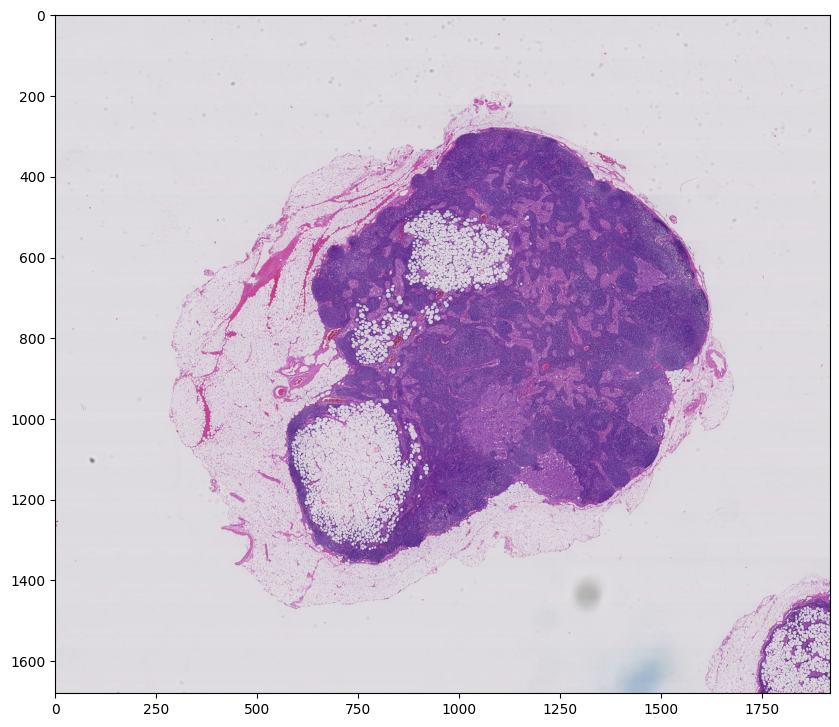

In [ ]:
slide=open_slide(slide_all_paths[0])
slide_image=read_slide(slide,x=0,y=0,level=5,width=slide.level_dimensions[5][0],height=slide.level_dimensions[5][1])

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)

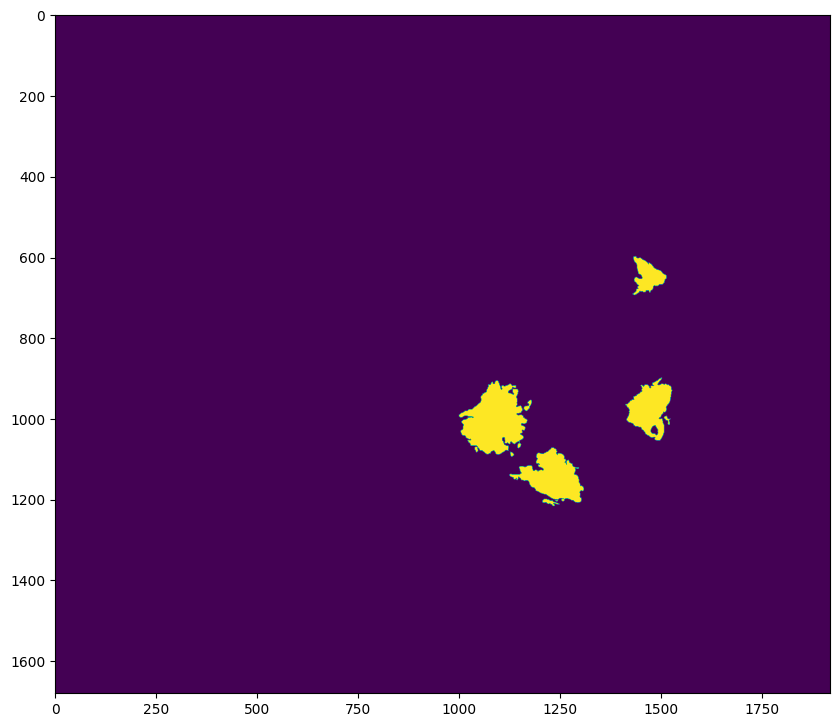

In [ ]:
mask=open_slide(mask_all_paths[0])
mask_image=read_slide(mask,x=0,y=0,level=5,width=slide.level_dimensions[5][0],height=slide.level_dimensions[5][1])[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(mask_image)

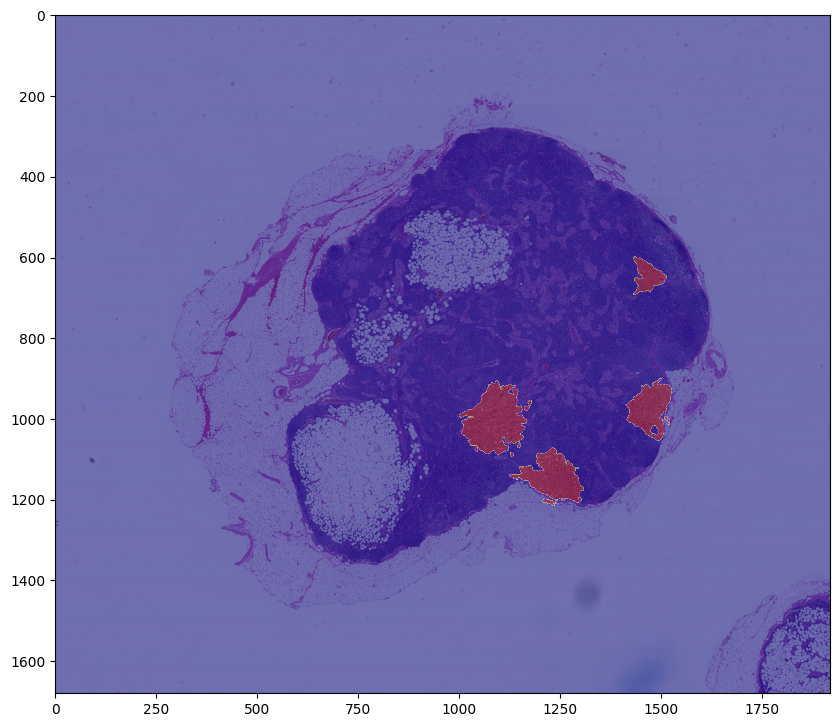

In [ ]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap='jet', alpha=0.5)

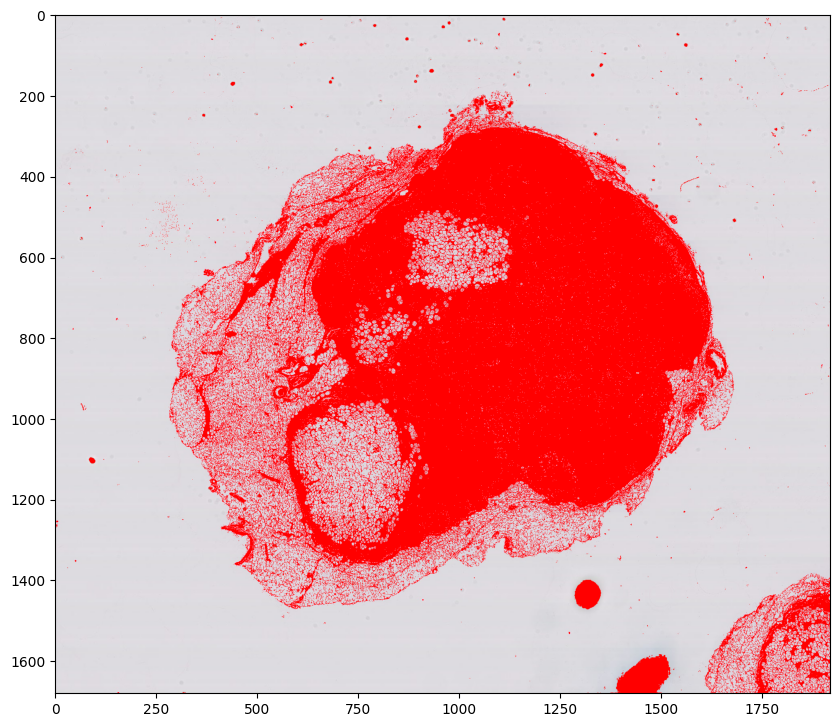

In [ ]:
tissue_pixels=find_tissue_pixels(slide_image)
masked_image=apply_mask(im=slide_image,mask=tissue_pixels)

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(masked_image)

In [ ]:
print("Slide includes %d levels", len(slide.level_dimensions))
for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i,slide.level_dimensions[i],slide.level_downsamples[i]))
    assert mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
    assert mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

# Verify downsampling works as expected
width, height = slide.level_dimensions[7]
assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

Slide includes %d levels 8
Level 0, dimensions: (61440, 53760) downsample factor 1
Level 1, dimensions: (30720, 26880) downsample factor 2
Level 2, dimensions: (15360, 13440) downsample factor 4
Level 3, dimensions: (7680, 6720) downsample factor 8
Level 4, dimensions: (3840, 3360) downsample factor 16
Level 5, dimensions: (1920, 1680) downsample factor 32
Level 6, dimensions: (960, 840) downsample factor 64
Level 7, dimensions: (480, 420) downsample factor 128


Slide a window over the original slide, save the images into directory '/4995/level-i/cancer/' or '/4995/level-i/healthy/', depending on whether the mask identifies cancerous cells in the image

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
def window_sliding(slide_path,level=0,intensity=0.8):
  slide=open_slide(slide_path)
  mask_path=slide_path[:-4]+'_mask.tif'
  mask=open_slide(mask_path)

  x=0
  while x+299<=slide.level_dimensions[level][0]:
    y=0
    while y+299<=slide.level_dimensions[level][1]:
      slide_window=read_slide(slide,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      mask_window=read_slide(mask,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      
      tissue_pixels=find_tissue_pixels(slide_window,intensity=intensity)
      percent_tissue = len(tissue_pixels) / float(slide_window.shape[0] * slide_window.shape[0])

      if percent_tissue>=0.25:
        if np.max(mask_window[:,:,0])>0:
          label='cancer'
        else:
          label='healthy'        
        out_slide=image.array_to_img(slide_window)
        image.save_img('./drive/My Drive/4995/level-'+str(level)+'/'+label+'/'+slide_path[slide_path.find('tumor'):-4]+'_x='+str(x)+'_y='+str(y)+'.jpg',out_slide,file_format='jpeg')   
      y+=299
    x+=299

Apply the sliding on 2 slides, at level=1, for training data. 

In [ ]:
# don't rerun this cell
window_sliding(slide_all_paths[0],level=1,intensity=0.8)
window_sliding(slide_all_paths[-2],level=1,intensity=0.8)

Get count of healthy and cancerous files, and balance the number by keeping them roughly the same.

In [24]:
def balance(healthy_path,cancer_path):
  import random
  healthy_imgs=[]
  for filename in os.listdir(healthy_path):
    healthy_imgs.append(healthy_path+filename)
  # print('healthy files count: '+str(len(healthy_imgs)))

  cancer_imgs=[]
  for filename in os.listdir(cancer_path):
    cancer_imgs.append(cancer_path+filename)
  # print('cancerous files count: '+str(len(cancer_imgs)))

  if len(cancer_imgs)<len(healthy_imgs):
    healthy_imgs=random.sample(healthy_imgs, len(cancer_imgs))
  elif len(cancer_imgs)>len(healthy_imgs):
    cancer_imgs=random.sample(cancer_imgs, len(healthy_imgs))
  else:
    pass
  # print('healthy patches count: '+str(len(healthy_imgs)))
  # print('cancerous patches count: '+str(len(cancer_imgs)))
  return healthy_imgs, cancer_imgs

Obtain training and testing dataset via train-test-split, inspired by HW2, and then move the files to '/4995/training/cancer/', '/4995/training/healthy/', '/4995/validation/cancer/', '/4995/validation/healthy/' accordingly. 

In [ ]:
# don't rerun this cell
import pathlib
all_image_paths=[filename for filename in healthy_imgs]+[filename for filename in cancer_imgs]
label_names=['healthy','cancer']
label_to_index = dict((name, index) for index, name in enumerate(label_names))
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                  for path in all_image_paths]

In [ ]:
# don't rerun this cell
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels, test_size=0.2, random_state=123)

In [ ]:
# don't rerun this cell
import shutil
for path in train_paths:
  if 'cancer' in path:
    shutil.move(path,'./drive/My Drive/4995/training/cancer/')
  else:
    shutil.move(path,'./drive/My Drive/4995/training/healthy/')
    
for path in test_paths:
  if 'cancer' in path:
    shutil.move(path,'./drive/My Drive/4995/validation/cancer/')
  else:
    shutil.move(path,'./drive/My Drive/4995/validation/healthy/')

Train the data by transfer learning using InceptionV3, with some data augmentation, and plot learning curve. 

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPool2D, Flatten
base_model = tf.keras.applications.InceptionV3(input_shape=(299,299,3),include_top=False,weights='imagenet')
base_model.trainable = False 
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE=299
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=10,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.05,
      zoom_range=0.05,
      horizontal_flip=True,
      vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './drive/My Drive/4995/training/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=100)
validation_generator = test_datagen.flow_from_directory(
        './drive/My Drive/4995/validation/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=100)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit_generator(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

Found 4734 images belonging to 2 classes.
Found 1131 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
48/48 [==============================] - 791s 17s/step - loss: 0.4734 - accuracy: 0.7589 - val_loss: 0.2347 - val_accuracy: 0.9054
Epoch 2/10
48/48 [==============================] - 98s 2s/step - loss: 0.2313 - accuracy: 0.9129 - val_loss: 0.2156 - val_accuracy: 0.9160
Epoch 3/10
48/48 [==============================] - 97s 2s/step - loss: 0.2087 - accuracy: 0.9182 - val_loss: 0.2066 - val_accuracy: 0.9293
Epoch 4/10
48/48 [==============================] - 98s 2s/step - loss: 0.1980 - accuracy: 0.9292 - val_loss: 0.1952 - val_accuracy: 0.9302
Epoch 5/10
48/48 [==============================] - 97s 2s/step - loss: 0.2007 - accuracy: 0.9221 - val_loss: 0.1918 - val_accuracy: 0.9302
Epoch 6/10
48/48 [==============================] - 97s 2s/step - loss: 0.1753 - accuracy: 0.9359 - val_loss: 0.1854 - val_accuracy: 0.9337
Epoch 7/10
48/48 [==============================] - 98s 2s/step - loss: 0.1780 - accuracy: 0.9330 - val_loss: 0.1825 - val_accuracy: 0.9372
Epoch 8/10
48/48 [

In [27]:
model.save("./drive/My Drive/4995/transfer_learning_model.h5")

Plotting function adapted from HW1 and HW2.

In [28]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

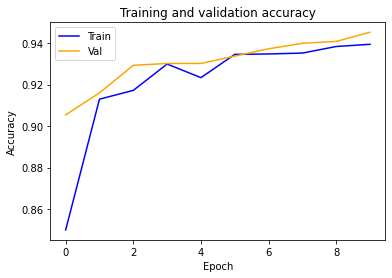

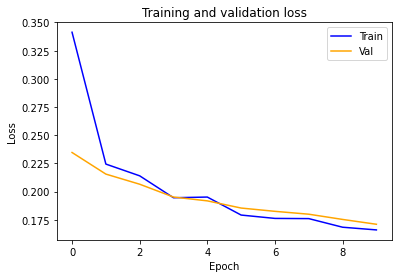

In [29]:
plot(history)

Build a model from scratch, train on the data, and plot the learning curve.

In [ ]:
from tensorflow.keras import datasets, layers, models
new_model = models.Sequential()
new_model.add(layers.Conv2D(4, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.Conv2D(8, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.Conv2D(16, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.MaxPooling2D())
new_model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.MaxPooling2D())
new_model.add(layers.Conv2D(64, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.MaxPooling2D())
new_model.add(layers.Conv2D(128, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.MaxPooling2D())
new_model.add(layers.Conv2D(256, (3, 3), activation='relu', 
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
new_model.add(layers.MaxPooling2D())
new_model.add(layers.Flatten())
new_model.add(layers.Dense(128, activation='relu'))
new_model.add(layers.Dense(16, activation='relu'))
new_model.add(layers.Dense(2, activation='softmax'))

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_188 (Conv2D)          (None, 297, 297, 4)       112       
_________________________________________________________________
conv2d_189 (Conv2D)          (None, 295, 295, 8)       296       
_________________________________________________________________
conv2d_190 (Conv2D)          (None, 293, 293, 16)      1168      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 146, 146, 16)      0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 144, 144, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 70, 70, 64)       

In [ ]:
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = new_model.fit_generator(
      train_generator,
      epochs=10,
      validation_data=validation_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
46/46 [==============================] - 94s 2s/step - loss: 0.6485 - accuracy: 0.5878 - val_loss: 0.4951 - val_accuracy: 0.7878
Epoch 2/10
46/46 [==============================] - 91s 2s/step - loss: 0.4492 - accuracy: 0.8056 - val_loss: 0.3040 - val_accuracy: 0.8683
Epoch 3/10
46/46 [==============================] - 91s 2s/step - loss: 0.2960 - accuracy: 0.8965 - val_loss: 0.2474 - val_accuracy: 0.9080
Epoch 4/10
46/46 [==============================] - 91s 2s/step - loss: 0.2237 - accuracy: 0.9177 - val_loss: 0.2438 - val_accuracy: 0.9089
Epoch 5/10
46/46 [==============================] - 91s 2s/step - loss: 0.1988 - accuracy: 0.9280 - val_loss: 0.2215 - val_accuracy: 0.9257
Epoch 6/10
46/46 [==============================] - 91s 2s/step - loss: 0.2142 - accuracy: 0.9254 - val_loss: 0.2616 - val_accuracy: 0.8886
Epoch 7/10
46/46 [==============================] - 91s 2s/step - loss: 0.2259 - accuracy: 0.9179 - val_loss: 0.2090 - val_accuracy: 0.9284
Epoch 8/10
46/46 [==

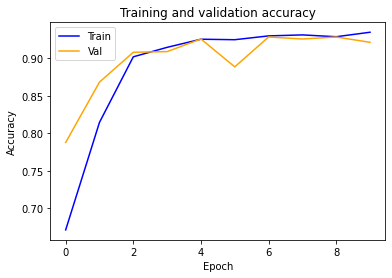

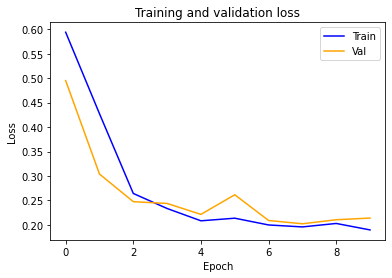

In [ ]:
plot(history)

In [ ]:
new_model.save("./drive/My Drive/4995/my_model.h5")

Using the model to predict on slide 110 at level 3. 

In [ ]:
train_generator.class_indices

In [ ]:
model=tf.keras.models.load_model('./drive/My Drive/4995/my_model.h5')
for i in range(10):
  test_im=Image.open('./drive/My Drive/4995/validation/cancer/'+os.listdir('./drive/My Drive/4995/validation/cancer/')[i])
  test_im=np.asarray(test_im, dtype="int32" )/255
  pred=model.predict(test_im.reshape(1,299,299,3))
  print(np.argmax(pred[0]))

1
1
0
1
1
0
0
1
0
1


In [31]:
def pred(slide_path, level=0, intensity=0.8, model='tl'):
  if model=='tl':
    model=tf.keras.models.load_model('./drive/My Drive/4995/transfer_learning_model.h5')
  else:
    model=tf.keras.models.load_model('./drive/My Drive/4995/my_model.h5')
  slide=open_slide(slide_path)
  mask_path=slide_path[:-4]+'_mask.tif'
  mask=open_slide(mask_path)

  pred_mask=np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]))

  x=0
  while x+299<= slide.level_dimensions[level][0]:
    y=0
    while y+299<= slide.level_dimensions[level][1]:
      slide_window=read_slide(slide,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      mask_window=read_slide(mask,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      
      tissue_pixels=find_tissue_pixels(slide_window,intensity=intensity)
      percent_tissue = len(tissue_pixels) / float(slide_window.shape[0] * slide_window.shape[0])

      if percent_tissue>=0.25:
        pred_slide=model.predict((slide_window/255).reshape(1,299,299,3))
        if np.argmax(pred_slide[0])==0:
          pred_mask[y:y+299, x:x+299]=1
      y+=299
    x+=299  

  return pred_mask

using the model from scratch:

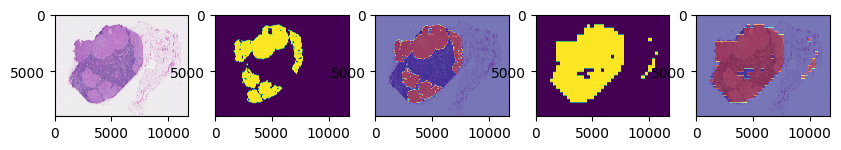

In [32]:
slide=open_slide('./drive/My Drive/4995/tumor_110.tif')
slide_image=read_slide(slide,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])
mask=open_slide('./drive/My Drive/4995/tumor_110_mask.tif')
mask_image=read_slide(mask,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])[:,:,0]
mask_pred=pred('./drive/My Drive/4995/tumor_110.tif', model='m',level=3)

plt.figure(figsize=(10,10), dpi=100)
plt.subplot(151)
plt.imshow(slide_image)
plt.subplot(152)
plt.imshow(mask_image)
plt.subplot(153)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap = "jet", alpha = 0.5)
plt.subplot(154)
plt.imshow(mask_pred)
plt.subplot(155)
plt.imshow(slide_image)
plt.imshow(mask_pred, cmap = "jet", alpha = 0.5)
plt.show()

using the transfer learning model:

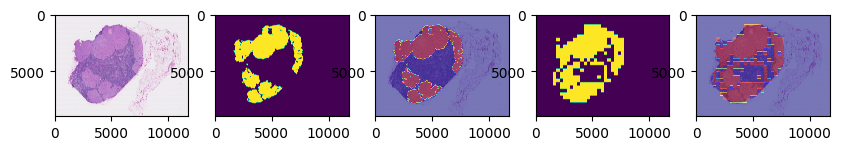

In [34]:
slide=open_slide('./drive/My Drive/4995/tumor_110.tif')
slide_image=read_slide(slide,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])
mask=open_slide('./drive/My Drive/4995/tumor_110_mask.tif')
mask_image=read_slide(mask,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])[:,:,0]
mask_pred=pred('./drive/My Drive/4995/tumor_110.tif', model='tl',level=3)

plt.figure(figsize=(10,10), dpi=100)
plt.subplot(151)
plt.imshow(slide_image)
plt.subplot(152)
plt.imshow(mask_image)
plt.subplot(153)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap = "jet", alpha = 0.5)
plt.subplot(154)
plt.imshow(mask_pred)
plt.subplot(155)
plt.imshow(slide_image)
plt.imshow(mask_pred, cmap = "jet", alpha = 0.5)
plt.show()

Evaluation(TP,FP,TN,FN,accuracy, precision, recall, F1 score)

In [35]:
def evaluate(slide_path, level=0, model='tl'):
  TP=0
  FP=0
  TN=0
  FN=0

  if model=='tl':
    model=tf.keras.models.load_model('./drive/My Drive/4995/transfer_learning_model.h5')
  else:
    model=tf.keras.models.load_model('./drive/My Drive/4995/my_model.h5')

  slide=open_slide(slide_path)
  mask_path=slide_path[:-4]+'_mask.tif'
  mask=open_slide(mask_path)
  pred_mask=pred(slide_path,level=level)
  
  x=0
  while x+299<= slide.level_dimensions[level][0]:
    y=0
    while y+299<= slide.level_dimensions[level][1]:
      mask_window=read_slide(mask,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      
      if pred_mask[y,x]==0:
        if np.max(mask_window)==1:
          FN+=1
        else:
          TN+=1
      else:
        if np.max(mask_window)==0:
          TP+=1
        else:
          FP+=1
      y+=299
    x+=299 

  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  accuracy=(TP+TN)/(TP+TN+FP+FN)
  F1=2*(precision*recall)/(precision+recall)

  print("Precision: "+str(precision))
  print("Recall: "+str(recall))
  print("Accuracy: "+str(accuracy))
  print("F1 score: "+str(F1))

transfer learning model evaluation

In [ ]:
evaluate('./drive/My Drive/4995/tumor_110.tif',level=3,model='tl')

Precision: 0.20149253731343283
Recall: 0.13846153846153847
Accuracy: 0.7568523430592397
F1 score: 0.16413373860182373


model from scratch evaluation

In [45]:
evaluate('./drive/My Drive/4995/tumor_110.tif',level=3,model='m')

Precision: 0.1394422310756972
Recall: 0.3723404255319149
Accuracy: 0.7568523430592397
F1 score: 0.20289855072463767


Add more training data with higher zoom level. 

In [ ]:
# don't rerun below cells

In [ ]:
window_sliding('./drive/My Drive/4995/tumor_091.tif',level=3,intensity=0.8)
window_sliding('./drive/My Drive/4995/tumor_110.tif',level=3,intensity=0.8)

In [ ]:
window_sliding('./drive/My Drive/4995/tumor_091.tif',level=4,intensity=0.8)
window_sliding('./drive/My Drive/4995/tumor_110.tif',level=4,intensity=0.8)

In [ ]:
window_sliding('./drive/My Drive/4995/tumor_091.tif',level=5,intensity=0.8)
window_sliding('./drive/My Drive/4995/tumor_110.tif',level=5,intensity=0.8)

In [ ]:
window_sliding('./drive/My Drive/4995/tumor_091.tif',level=6,intensity=0.8)
window_sliding('./drive/My Drive/4995/tumor_110.tif',level=6,intensity=0.8)

In [ ]:
new_all_image_paths=[]
new_all_labels=[]
for l in range(3,7):
  healthy_imgs, cancer_imgs = balance(healthy_path='./drive/My Drive/4995/level-'+str(l)+'/healthy/',cancer_path='./drive/My Drive/4995/level-'+str(l)+'/cancer/')
  import pathlib
  all_image_paths=[filename for filename in healthy_imgs]+[filename for filename in cancer_imgs]
  label_names=['healthy','cancer']
  label_to_index = dict((name, index) for index, name in enumerate(label_names))
  all_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
  new_all_image_paths.extend(all_image_paths)
  new_all_labels.extend(all_labels)

for i in range(len(new_all_image_paths)):
  old=new_all_image_paths[i]
  os.rename(old, old[:old.find('.jpg')]+'_new'+old[old.find('.jpg'):])
  new_all_image_paths[i]=old[:old.find('.jpg')]+'_new'+old[old.find('.jpg'):])

In [ ]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(new_all_image_paths, new_all_labels, test_size=0.2, random_state=123)

In [ ]:
import shutil
for path in train_paths:
  if 'cancer' in path:
    try:
      shutil.move(path,'./drive/My Drive/4995/training/cancer/')
    except shutil.Error:
      pass
  else:
    try:
      shutil.move(path,'./drive/My Drive/4995/training/healthy/')
    except shutil.Error:
      pass
    
for path in test_paths:
  if 'cancer' in path:
    try:
      shutil.move(path,'./drive/My Drive/4995/validation/cancer/')
    except shutil.Error:
      pass
  else:
    try:
     shutil.move(path,'./drive/My Drive/4995/validation/healthy/')
    except shutil.Error:
      pass

Found 5290 images belonging to 2 classes.
Found 1272 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
53/53 [==============================] - 1407s 26s/step - loss: 0.2192 - accuracy: 0.9102 - val_loss: 0.2315 - val_accuracy: 0.9112
Epoch 2/10
53/53 [==============================] - 110s 2s/step - loss: 0.1896 - accuracy: 0.9282 - val_loss: 0.2414 - val_accuracy: 0.9112
Epoch 3/10
53/53 [==============================] - 110s 2s/step - loss: 0.1890 - accuracy: 0.9276 - val_loss: 0.2068 - val_accuracy: 0.9222
Epoch 4/10
53/53 [==============================] - 110s 2s/step - loss: 0.1859 - accuracy: 0.9287 - val_loss: 0.2067 - val_accuracy: 0.9237
Epoch 5/10
53/53 [==============================] - 110s 2s/step - loss: 0.1758 - accuracy: 0.9344 - val_loss: 0.2039 - val_accuracy: 0.9198
Epoch 6/10
53/53 [==============================] - 111s 2s/step - loss: 0.1800 - accuracy: 0.9306 - val_loss: 0.1987 - val_accuracy: 0.9245
Epoch 7/10
53/53 [==============================] - 110s 2s/step - loss: 0.1742 - accuracy: 0.9319 - val_loss: 0.1986 - val_accuracy: 0.9277
Epoch 8/10


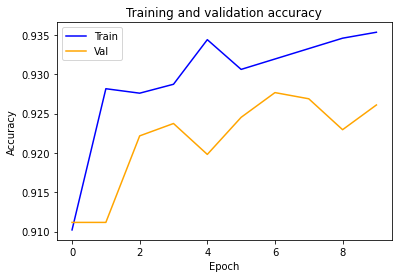

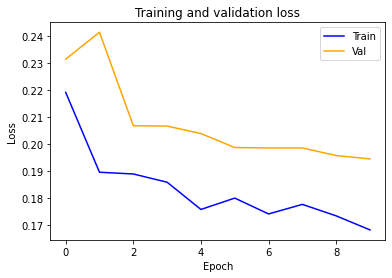

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=10,
      width_shift_range=0.05,
      height_shift_range=0.05,
      shear_range=0.05,
      zoom_range=0.05,
      horizontal_flip=True,
      vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './drive/My Drive/4995/training/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=100)
validation_generator = test_datagen.flow_from_directory(
        './drive/My Drive/4995/validation/',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=100)
model=tf.keras.models.load_model('./drive/My Drive/4995/transfer_learning_model.h5')
history=model.fit_generator(
      train_generator,
      epochs=10,
      validation_data=validation_generator)
plot(history)
model.save('./drive/My Drive/4995/new_transfer_learning_model.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
53/53 [==============================] - 118s 2s/step - loss: 0.1678 - accuracy: 0.9372 - val_loss: 0.1975 - val_accuracy: 0.9214
Epoch 2/10
53/53 [==============================] - 115s 2s/step - loss: 0.1633 - accuracy: 0.9365 - val_loss: 0.1938 - val_accuracy: 0.9253
Epoch 3/10
53/53 [==============================] - 116s 2s/step - loss: 0.1610 - accuracy: 0.9406 - val_loss: 0.1976 - val_accuracy: 0.9324
Epoch 4/10
53/53 [==============================] - 116s 2s/step - loss: 0.1640 - accuracy: 0.9380 - val_loss: 0.2312 - val_accuracy: 0.9190
Epoch 5/10
53/53 [==============================] - 116s 2s/step - loss: 0.1684 - accuracy: 0.9357 - val_loss: 0.1912 - val_accuracy: 0.9316
Epoch 6/10
53/53 [==============================] - 117s 2s/step - loss: 0.1539 - accuracy: 0.9425 - val_loss: 0.1848 - val_accuracy: 0.9277
Epoch 7/10
53/53 [==============================] - 117s 2s/step - loss: 0.1550 - accuracy: 0.9437 - val_loss: 0.1815 - val_accuracy: 0.9308
Epoch 8/10
53

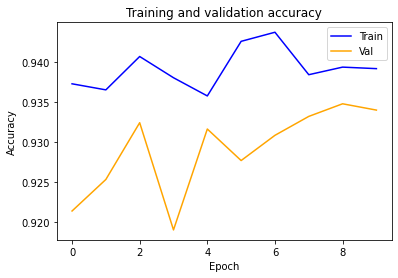

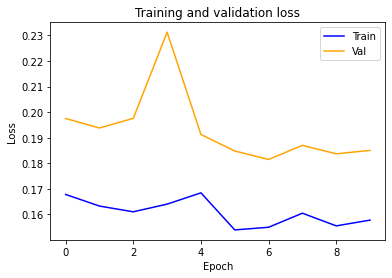

In [38]:
new_model=tf.keras.models.load_model('./drive/My Drive/4995/my_model.h5')
history=model.fit_generator(
      train_generator,
      epochs=10,
      validation_data=validation_generator)
plot(history)
new_model.save('./drive/My Drive/4995/new_my_model.h5')

In [39]:
def new_pred(slide_path, level=0, intensity=0.8, model='tl'):
  if model=='tl':
    model=tf.keras.models.load_model('./drive/My Drive/4995/new_transfer_learning_model.h5')
  else:
    model=tf.keras.models.load_model('./drive/My Drive/4995/new_my_model.h5')
  slide=open_slide(slide_path)
  mask_path=slide_path[:-4]+'_mask.tif'
  mask=open_slide(mask_path)

  pred_mask=np.zeros((slide.level_dimensions[level][1], slide.level_dimensions[level][0]))

  x=0
  while x+299<= slide.level_dimensions[level][0]:
    y=0
    while y+299<= slide.level_dimensions[level][1]:
      slide_window=read_slide(slide,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      mask_window=read_slide(mask,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      
      tissue_pixels=find_tissue_pixels(slide_window,intensity=intensity)
      percent_tissue = len(tissue_pixels) / float(slide_window.shape[0] * slide_window.shape[0])

      if percent_tissue>=0.25:
        pred_slide=model.predict((slide_window/255).reshape(1,299,299,3))
        if np.argmax(pred_slide[0])==0:
          pred_mask[y:y+299, x:x+299]=1
      y+=299
    x+=299  

  return pred_mask

Predict on slide_110 using model from scratch

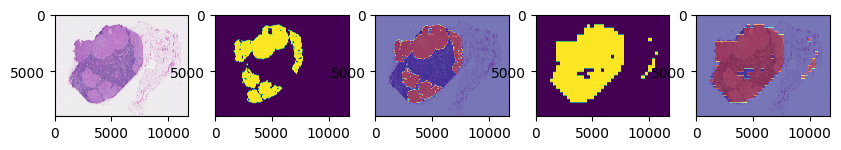

In [40]:
slide=open_slide('./drive/My Drive/4995/tumor_110.tif')
slide_image=read_slide(slide,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])
mask=open_slide('./drive/My Drive/4995/tumor_110_mask.tif')
mask_image=read_slide(mask,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])[:,:,0]
mask_pred=new_pred('./drive/My Drive/4995/tumor_110.tif', model='m',level=3)

plt.figure(figsize=(10,10), dpi=100)
plt.subplot(151)
plt.imshow(slide_image)
plt.subplot(152)
plt.imshow(mask_image)
plt.subplot(153)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap = "jet", alpha = 0.5)
plt.subplot(154)
plt.imshow(mask_pred)
plt.subplot(155)
plt.imshow(slide_image)
plt.imshow(mask_pred, cmap = "jet", alpha = 0.5)
plt.show()

Predict on slide_110 using transfer learning model

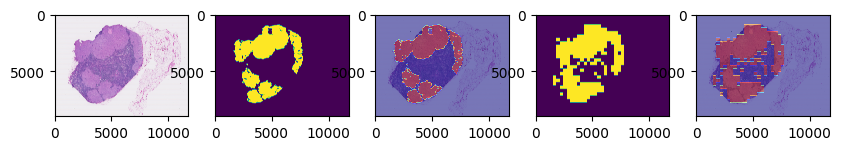

In [41]:
slide=open_slide('./drive/My Drive/4995/tumor_110.tif')
slide_image=read_slide(slide,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])
mask=open_slide('./drive/My Drive/4995/tumor_110_mask.tif')
mask_image=read_slide(mask,x=0,y=0,level=3,width=slide.level_dimensions[3][0],height=slide.level_dimensions[3][1])[:,:,0]
mask_pred=new_pred('./drive/My Drive/4995/tumor_110.tif', model='tl',level=3)

plt.figure(figsize=(10,10), dpi=100)
plt.subplot(151)
plt.imshow(slide_image)
plt.subplot(152)
plt.imshow(mask_image)
plt.subplot(153)
plt.imshow(slide_image)
plt.imshow(mask_image, cmap = "jet", alpha = 0.5)
plt.subplot(154)
plt.imshow(mask_pred)
plt.subplot(155)
plt.imshow(slide_image)
plt.imshow(mask_pred, cmap = "jet", alpha = 0.5)
plt.show()

Evaluations

In [42]:
def new_evaluate(slide_path, level=0, model='tl'):
  TP=0
  FP=0
  TN=0
  FN=0

  if model=='tl':
    model=tf.keras.models.load_model('./drive/My Drive/4995/new_transfer_learning_model.h5')
  else:
    model=tf.keras.models.load_model('./drive/My Drive/4995/new_my_model.h5')

  slide=open_slide(slide_path)
  mask_path=slide_path[:-4]+'_mask.tif'
  mask=open_slide(mask_path)
  pred_mask=pred(slide_path,level=level)
  
  x=0
  while x+299<= slide.level_dimensions[level][0]:
    y=0
    while y+299<= slide.level_dimensions[level][1]:
      mask_window=read_slide(mask,x=x*int(slide.level_downsamples[level]),y=y*int(slide.level_downsamples[level]),level=level,width=299,height=299)
      
      if pred_mask[y,x]==0:
        if np.max(mask_window)==1:
          FN+=1
        else:
          TN+=1
      else:
        if np.max(mask_window)==0:
          TP+=1
        else:
          FP+=1
      y+=299
    x+=299 

  precision=TP/(TP+FP)
  recall=TP/(TP+FN)
  accuracy=(TP+TN)/(TP+TN+FP+FN)
  F1=2*(precision*recall)/(precision+recall)

  print("Precision: "+str(precision))
  print("Recall: "+str(recall))
  print("Accuracy: "+str(accuracy))
  print("F1 score: "+str(F1))

transfer learning evaluation

In [43]:
new_evaluate('./drive/My Drive/4995/tumor_110.tif',level=3,model='tl')

Precision: 0.1394422310756972
Recall: 0.3723404255319149
Accuracy: 0.7568523430592397
F1 score: 0.20289855072463767


model from scratch evaluation

In [44]:
new_evaluate('./drive/My Drive/4995/tumor_110.tif',level=3,model='m')

Precision: 0.1394422310756972
Recall: 0.3723404255319149
Accuracy: 0.7568523430592397
F1 score: 0.20289855072463767
